In [ ]:
!pip install wfdb --quiet
!pip install neurokit2 --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 74.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 15.4 MB/s eta 0:00:00


In [ ]:
RAW_DIR = "/content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0"
os.listdir(RAW_DIR)[:20]


NameError: name 'os' is not defined

In [ ]:
import wfdb
import os
test_file = RAW_DIR + "/bidmc01"
record = wfdb.rdrecord(test_file)
record


In [ ]:
signals = record.p_signal
sig_names = [name.replace(',', '').strip().lower() for name in record.sig_name]

print("Clean Signal Names:", sig_names)

ecg = signals[:, sig_names.index('ii')]
ppg = signals[:, sig_names.index('pleth')]

print("ECG shape:", ecg.shape)
print("PPG shape:", ppg.shape)


Clean Signal Names: ['resp', 'pleth', 'v', 'avr', 'ii']
ECG shape: (60001,)
PPG shape: (60001,)


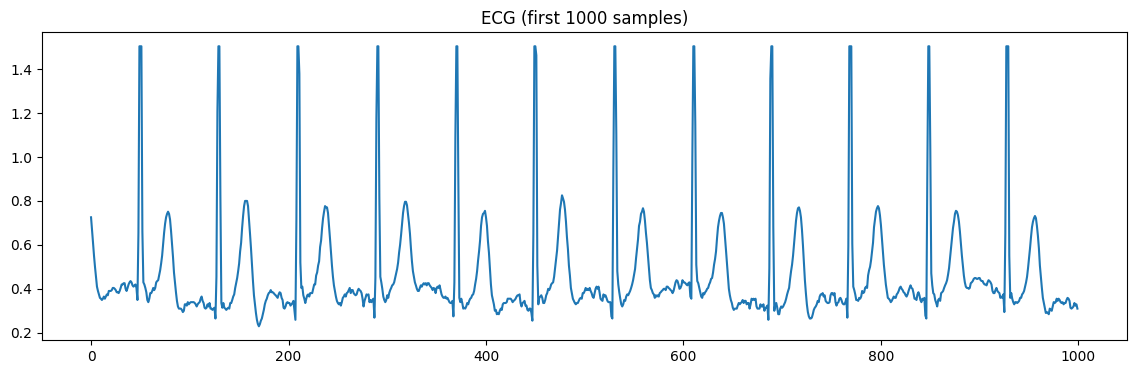

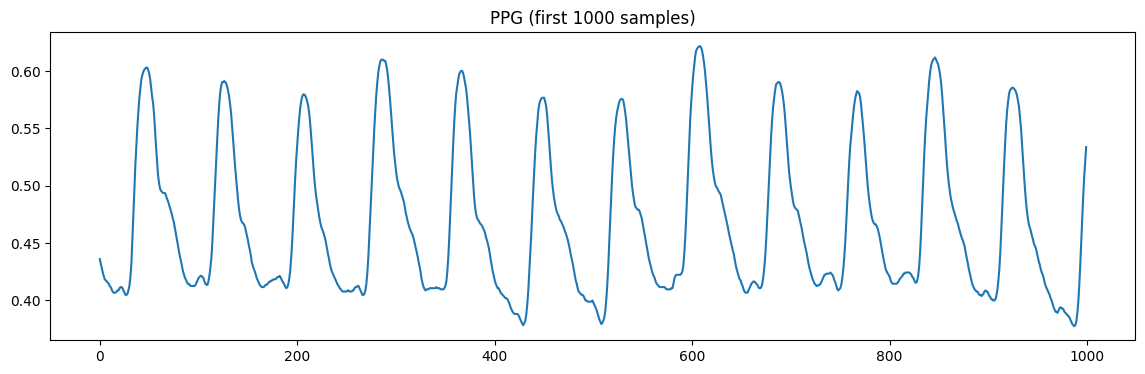

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(ecg[:1000])
plt.title("ECG (first 1000 samples)")
plt.show()

plt.figure(figsize=(14,4))
plt.plot(ppg[:1000])
plt.title("PPG (first 1000 samples)")
plt.show()


In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(x, fs=125, low=0.5, high=40):
    nyq = 0.5*fs
    b, a = butter(3, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, x)

def lowpass_filter(x, fs=125, cutoff=8):
    nyq = 0.5*fs
    b, a = butter(3, cutoff/nyq, btype='low')
    return filtfilt(b, a, x)

ecg_f = bandpass_filter(ecg)
ppg_f = lowpass_filter(ppg)


In [ ]:
from scipy.signal import find_peaks
import numpy as np

fs = record.fs
ecg_sq = np.abs(ecg_f)
peaks, _ = find_peaks(ecg_sq, distance=int(0.3*fs), prominence=np.std(ecg_sq)*0.5)

rr = np.diff(peaks) / fs
hr = 60 / rr

print("Detected peaks:", len(peaks))
print("Heart rate range:", hr.min(), "to", hr.max())


Detected peaks: 795
Heart rate range: 74.25742574257426 to 202.7027027027027


In [ ]:
from scipy.signal import butter, filtfilt

fs = record.fs

def bandpass_ecg(x):
    # 0.5–35 Hz ideal for QRS detection
    nyq = 0.5 * fs
    b, a = butter(3, [0.5/nyq, 35/nyq], btype='band')
    return filtfilt(b, a, x)

def lowpass_ppg(x):
    # 8 Hz cutoff eliminates noise
    nyq = 0.5 * fs
    b, a = butter(3, 8/nyq, btype='low')
    return filtfilt(b, a, x)

ecg_f = bandpass_ecg(ecg)
ppg_f = lowpass_ppg(ppg)

print("Filtered ECG & PPG successfully!")


Filtered ECG & PPG successfully!


In [ ]:
import numpy as np
from scipy.signal import find_peaks

ecg_abs = np.abs(ecg_f)

# Physiological RR distance: 300 ms minimum
min_dist = int(0.3 * fs)

peaks, _ = find_peaks(ecg_abs, distance=min_dist, prominence=np.std(ecg_abs)*0.6)

print("R-peaks detected:", len(peaks))

# Compute RR + HR
rr_intervals = np.diff(peaks) / fs   # seconds
hr = 60 / rr_intervals

print("HR range:", hr.min(), "to", hr.max())


R-peaks detected: 775
HR range: 74.25742574257426 to 202.7027027027027


In [ ]:
hr_array = np.zeros(len(ecg_f)) + np.nan

for i in range(1, len(peaks)):
    p = peaks[i]
    hr_array[p] = hr[i-1]

# fill missing values with last known HR
import pandas as pd
hr_array = pd.Series(hr_array).fillna(method="ffill").fillna(method="bfill").to_numpy()

print("HR array created:", hr_array.shape)


HR array created: (60001,)


/tmp/ipython-input-3940904055.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hr_array = pd.Series(hr_array).fillna(method="ffill").fillna(method="bfill").to_numpy()


In [ ]:
WINDOW = 360
STRIDE = 180

ecg_windows = []
ppg_windows = []
hr_windows = []
amp_windows = []

for start in range(0, len(ecg_f)-WINDOW, STRIDE):
    end = start + WINDOW

    w_ecg = ecg_f[start:end]
    w_ppg = ppg_f[start:end]

    # HR in window = median HR
    w_hr = np.median(hr_array[start:end])

    # PPG amplitude
    w_amp = w_ppg.max() - w_ppg.min()

    ecg_windows.append(w_ecg)
    ppg_windows.append(w_ppg)
    hr_windows.append(w_hr)
    amp_windows.append(w_amp)

print("Total windows:", len(ecg_windows))


Total windows: 332


In [ ]:
baseline_amp = np.median(amp_windows)
amp_ratio = np.array(amp_windows) / baseline_amp

print("Baseline amplitude:", baseline_amp)


Baseline amplitude: 0.2266716299564915


In [ ]:
labels = []

for ratio, hr in zip(amp_ratio, hr_windows):

    if ratio < 0.4 or hr < 40 or hr > 130:
        labels.append(2)   # Critical
    elif ratio < 0.7 or hr < 50 or hr > 110:
        labels.append(1)   # Warning
    else:
        labels.append(0)   # Normal

print("Label counts:", {0:labels.count(0), 1:labels.count(1), 2:labels.count(2)})


Label counts: {0: 316, 1: 12, 2: 4}


In [ ]:
import numpy as np

SAVE = "/content/drive/MyDrive/BIDMC_Fusion_Project/dataset"

np.save(SAVE + "/X_ecg.npy", np.array(ecg_windows, dtype=np.float32))
np.save(SAVE + "/X_ppg.npy", np.array(ppg_windows, dtype=np.float32))
np.save(SAVE + "/y.npy", np.array(labels, dtype=np.int64))

print("Saved dataset successfully!")


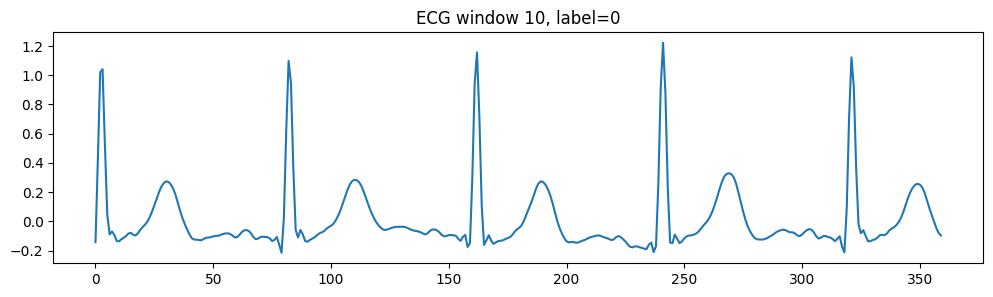

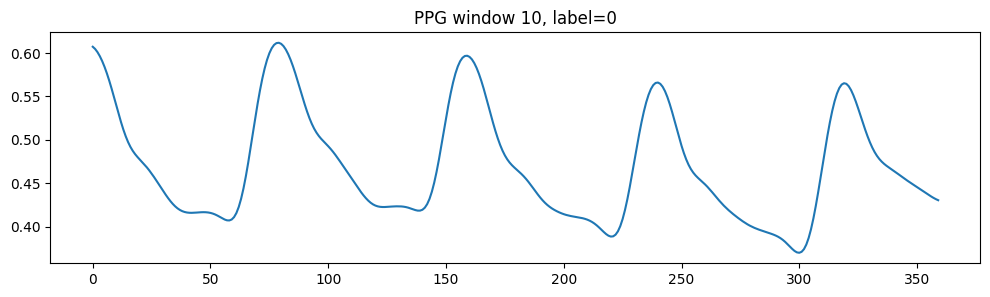

HR: 93.75
PPG amplitude: 0.24166982737575154
amp_ratio: 1.066167069174642


In [ ]:
i = 10

plt.figure(figsize=(12,3))
plt.plot(ecg_windows[i])
plt.title(f"ECG window {i}, label={labels[i]}")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(ppg_windows[i])
plt.title(f"PPG window {i}, label={labels[i]}")
plt.show()

print("HR:", hr_windows[i])
print("PPG amplitude:", amp_windows[i])
print("amp_ratio:", amp_ratio[i])


In [ ]:
# For all records now
import os, glob
import numpy as np
import pandas as pd
import wfdb
from scipy.signal import butter, filtfilt, find_peaks
from tqdm import tqdm

BASE = "/content/drive/MyDrive/BIDMC_Fusion_Project"
RAW_DIR = os.path.join(BASE, "raw", "bidmc-ppg-and-respiration-dataset-1.0.0")
SAVE_DIR = os.path.join(BASE, "dataset")

WINDOW = 360
STRIDE = 180

# ECG + PPG filters
def bandpass_ecg(x, fs):
    nyq = 0.5 * fs
    b, a = butter(3, [0.5/nyq, 35/nyq], btype="band")
    return filtfilt(b, a, x)

def lowpass_ppg(x, fs):
    nyq = 0.5 * fs
    b, a = butter(3, 8/nyq, btype="low")
    return filtfilt(b, a, x)

# Process one record
def process_record(path):
    record = wfdb.rdrecord(path)

    signals = record.p_signal
    fs = record.fs

    sig_names = [n.replace(",", "").strip().lower() for n in record.sig_name]

    # ECG lead selection
    if "ii" in sig_names:
        ecg = signals[:, sig_names.index("ii")]
    else:
        # fallback to first signal
        ecg = signals[:, 0]

    # PPG selection
    if "pleth" in sig_names:
        ppg = signals[:, sig_names.index("pleth")]
    else:
        return None

    # Filtering
    ecg_f = bandpass_ecg(ecg, fs)
    ppg_f = lowpass_ppg(ppg, fs)

    # R-peaks
    ecg_abs = np.abs(ecg_f)
    peaks, _ = find_peaks(ecg_abs, distance=int(0.3*fs), prominence=np.std(ecg_abs)*0.6)

    # HR calc
    if len(peaks) < 2:
        return None

    rr = np.diff(peaks) / fs
    hr = 60 / rr

    hr_array = np.zeros(len(ecg_f)) + np.nan
    for i in range(1, len(peaks)):
        hr_array[peaks[i]] = hr[i-1]

    hr_array = pd.Series(hr_array).fillna(method="ffill").fillna(method="bfill").to_numpy()

    # Windowing
    ecg_w = []
    ppg_w = []
    hr_w = []
    amp_w = []

    for start in range(0, len(ecg_f)-WINDOW, STRIDE):
        end = start + WINDOW

        w_ecg = ecg_f[start:end]
        w_ppg = ppg_f[start:end]

        # HR in window
        w_hr = np.median(hr_array[start:end])

        # PPG amplitude
        w_amp = w_ppg.max() - w_ppg.min()

        ecg_w.append(w_ecg)
        ppg_w.append(w_ppg)
        hr_w.append(w_hr)
        amp_w.append(w_amp)

    return np.array(ecg_w), np.array(ppg_w), np.array(hr_w), np.array(amp_w), fs


# FINAL DATA HOLDERS
ALL_ECG = []
ALL_PPG = []
ALL_HR = []
ALL_AMP = []
ALL_LABELS = []
META = []

files = sorted(glob.glob(os.path.join(RAW_DIR, "bidmc*.hea")))
print("Total records found:", len(files))

for hea in tqdm(files):
    path = hea.replace(".hea", "")

    result = process_record(path)

    if result is None:
        print("Skipped:", path)
        continue

    ecg_w, ppg_w, hr_w, amp_w, fs = result

    # Amplitude baseline for this record
    baseline_amp = np.median(amp_w)
    amp_ratio = amp_w / baseline_amp

    # Labels
    labels = []
    for ar, hr in zip(amp_ratio, hr_w):
        if ar < 0.4 or hr < 40 or hr > 130:
            labels.append(2)  # Critical
        elif ar < 0.7 or hr < 50 or hr > 110:
            labels.append(1)  # Warning
        else:
            labels.append(0)  # Normal

    # Append to global
    ALL_ECG.append(ecg_w)
    ALL_PPG.append(ppg_w)
    ALL_HR.extend(hr_w)
    ALL_AMP.extend(amp_w)
    ALL_LABELS.extend(labels)

    # Add to metadata
    for i in range(len(labels)):
        META.append({
            "record": os.path.basename(path),
            "window_id": i,
            "hr": hr_w[i],
            "amp": amp_w[i],
            "label": labels[i]
        })


# Convert all to numpy
X_ECG = np.vstack(ALL_ECG)
X_PPG = np.vstack(ALL_PPG)
Y = np.array(ALL_LABELS)

print("Final shapes:")
print("ECG:", X_ECG.shape)
print("PPG:", X_PPG.shape)
print("Labels:", Y.shape)

# Save dataset
np.save(os.path.join(SAVE_DIR, "X_ecg.npy"), X_ECG)
np.save(os.path.join(SAVE_DIR, "X_ppg.npy"), X_PPG)
np.save(os.path.join(SAVE_DIR, "y.npy"), Y)

# Save metadata
df = pd.DataFrame(META)
df.to_csv(os.path.join(SAVE_DIR, "metadata.csv"), index=False)

print("\nDataset Saved.")
print("Label distribution:", df["label"].value_counts().to_dict())



Total records found: 106


  0%|          | 0/106 [00:00<?, ?it/s]/tmp/ipython-input-2862180488.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hr_array = pd.Series(hr_array).fillna(method="ffill").fillna(method="bfill").to_numpy()
  2%|▏         | 2/106 [00:00<00:09, 10.48it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc01n


  5%|▍         | 5/106 [00:00<00:20,  4.87it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc02n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc03n


  8%|▊         | 9/106 [00:01<00:11,  8.62it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc04n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc05n


 14%|█▍        | 15/106 [00:01<00:05, 15.30it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc06n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc07n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc08n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc09n


 22%|██▏       | 23/106 [00:01<00:03, 23.49it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc10n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc11n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc12n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc13n


 29%|██▉       | 31/106 [00:02<00:02, 28.99it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc14n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc15n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc16n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc17n


 37%|███▋      | 39/106 [00:02<00:02, 31.87it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc18n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc19n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc20n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc21n


 44%|████▍     | 47/106 [00:02<00:01, 32.40it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc22n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc23n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc24n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc25n


 52%|█████▏    | 55/106 [00:02<00:01, 32.65it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc26n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc27n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc28n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc29n


 59%|█████▉    | 63/106 [00:02<00:01, 33.84it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc30n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc31n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc32n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc33n


 67%|██████▋   | 71/106 [00:03<00:01, 30.76it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc34n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc35n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc36n


 71%|███████   | 75/106 [00:03<00:01, 25.61it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc37n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc38n


 76%|███████▋  | 81/106 [00:03<00:01, 20.71it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc39n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc40n


 79%|███████▉  | 84/106 [00:03<00:01, 20.08it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc41n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc42n


 82%|████████▏ | 87/106 [00:04<00:01, 17.25it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc43n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc44n


 86%|████████▌ | 91/106 [00:04<00:00, 16.79it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc45n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc46n


 90%|████████▉ | 95/106 [00:04<00:00, 16.94it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc47n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc48n


 92%|█████████▏| 97/106 [00:04<00:00, 11.79it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc49n


 93%|█████████▎| 99/106 [00:05<00:00,  9.65it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc50n


 97%|█████████▋| 103/106 [00:05<00:00,  9.94it/s]

Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc51n
Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc52n


100%|██████████| 106/106 [00:05<00:00, 18.01it/s]


Skipped: /content/drive/MyDrive/BIDMC_Fusion_Project/raw/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc53n
Final shapes:
ECG: (17596, 360)
PPG: (17596, 360)
Labels: (17596,)

Dataset Saved.
Label distribution: {0: 10068, 2: 5464, 1: 2064}


In [ ]:
import numpy as np
import pandas as pd
import os

BASE = "/content/drive/MyDrive/BIDMC_Fusion_Project/dataset"

X_ecg = np.load(BASE + "/X_ecg.npy")
X_ppg = np.load(BASE + "/X_ppg.npy")
y = np.load(BASE + "/y.npy")

meta = pd.read_csv(BASE + "/metadata.csv")

print("ECG shape:", X_ecg.shape)
print("PPG shape:", X_ppg.shape)
print("Labels shape:", y.shape)
print("Label distribution:", pd.Series(y).value_counts().to_dict())


ECG shape: (17596, 360)
PPG shape: (17596, 360)
Labels shape: (17596,)
Label distribution: {0: 10068, 2: 5464, 1: 2064}


In [ ]:
#Train/Validation/Test Split (Subject-Independent)
from sklearn.model_selection import train_test_split

# first split into train + temp
X_ecg_train, X_ecg_temp, X_ppg_train, X_ppg_temp, y_train, y_temp = train_test_split(
    X_ecg, X_ppg, y, test_size=0.30, random_state=42, stratify=y)

# split temp into validation + test
X_ecg_val, X_ecg_test, X_ppg_val, X_ppg_test, y_val, y_test = train_test_split(
    X_ecg_temp, X_ppg_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_ecg_train.shape)
print("Val:  ", X_ecg_val.shape)
print("Test: ", X_ecg_test.shape)


Train: (12317, 360)
Val:   (2639, 360)
Test:  (2640, 360)


In [ ]:
# Normalization function
def normalize(x):
    mean = x.mean(axis=1, keepdims=True)
    std = x.std(axis=1, keepdims=True) + 1e-8
    return (x - mean) / std

X_ecg_train_n = normalize(X_ecg_train)
X_ecg_val_n   = normalize(X_ecg_val)
X_ecg_test_n  = normalize(X_ecg_test)

X_ppg_train_n = normalize(X_ppg_train)
X_ppg_val_n   = normalize(X_ppg_val)
X_ppg_test_n  = normalize(X_ppg_test)

print("Normalization done.")


Normalization done.


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def build_branch(input_shape):
    inp = Input(shape=input_shape)

    x = Reshape((360,1))(inp)

    x = Conv1D(16, 7, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)

    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)

    return inp, x

# ECG branch
inp_ecg, feat_ecg = build_branch((360,))

# PPG branch
inp_ppg, feat_ppg = build_branch((360,))

# Fusion
fusion = concatenate([feat_ecg, feat_ppg])
dense = Dense(64, activation='relu')(fusion)
drop = Dropout(0.3)(dense)
out = Dense(3, activation='softmax')(drop)

model = Model(inputs=[inp_ecg, inp_ppg], outputs=out)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 360)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 360)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 360, 1)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 360, 1)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 360, 16)   │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 360, 16)   │        128 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 180, 16)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 180, 16)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 180, 32)   │      2,592 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 180, 32)   │      2,592 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 90, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 90, 32)    │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 90, 64)    │      6,208 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 64)    │      6,208 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 26,307 (102.76 KB)

 Trainable params: 26,307 (102.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy'
)

history = model.fit(
    [X_ecg_train_n, X_ppg_train_n],
    y_train,
    validation_data=([X_ecg_val_n, X_ppg_val_n], y_val),
    epochs=25,
    batch_size=64,
    callbacks=[es],
    verbose=1
)


Epoch 1/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.5799 - loss: 0.9479 - val_accuracy: 0.6696 - val_loss: 0.8251
Epoch 2/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.6598 - loss: 0.8155 - val_accuracy: 0.6593 - val_loss: 0.7172
Epoch 3/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.6946 - loss: 0.7092 - val_accuracy: 0.7302 - val_loss: 0.6115
Epoch 4/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7512 - loss: 0.6108 - val_accuracy: 0.8143 - val_loss: 0.5425
Epoch 5/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8107 - loss: 0.5293 - val_accuracy: 0.8689 - val_loss: 0.4260
Epoch 6/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8369 - loss: 0.4901 - val_accuracy: 0.8651 - val_loss: 0.4053
Epoch 7/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.8538 - loss: 0.4467 - val_accuracy: 0.8719 - val_loss: 0.4083
Epoch 8/25
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.8677 - loss: 0.4167 - 

In [ ]:
loss, acc = model.evaluate([X_ecg_test_n, X_ppg_test_n], y_test)
print("Test Accuracy:", acc)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9038 - loss: 0.2989
Test Accuracy: 0.8958333134651184


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict([X_ecg_test_n, X_ppg_test_n])
y_pred = np.argmax(y_pred, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[1457   12   42]
 [  75  206   28]
 [ 115    3  702]]
              precision    recall  f1-score   support

           0     0.8846    0.9643    0.9227      1511
           1     0.9321    0.6667    0.7774       309
           2     0.9093    0.8561    0.8819       820

    accuracy                         0.8958      2640
   macro avg     0.9087    0.8290    0.8607      2640
weighted avg     0.8979    0.8958    0.8930      2640



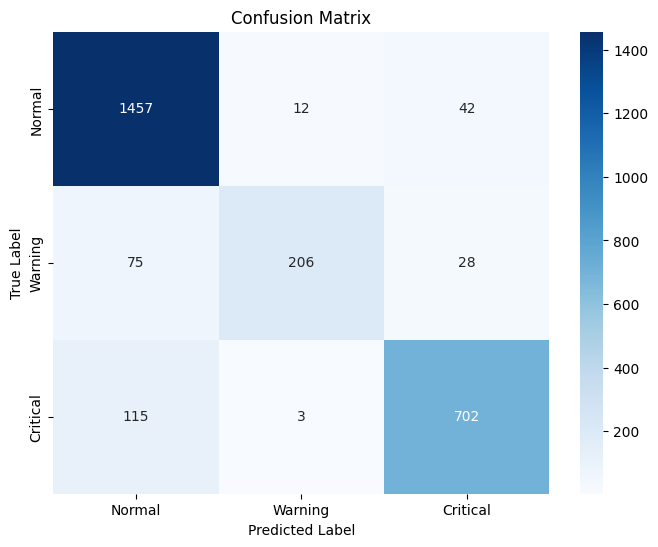

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ["Normal", "Warning", "Critical"]

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
import os

save_dir = BASE + "/model"
os.makedirs(save_dir, exist_ok=True)   # create folder if missing

model.save("/content/drive/MyDrive/BIDMC_Fusion_Project/model/fusion_model.keras")
print("Model saved successfully!")

Model saved successfully!


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


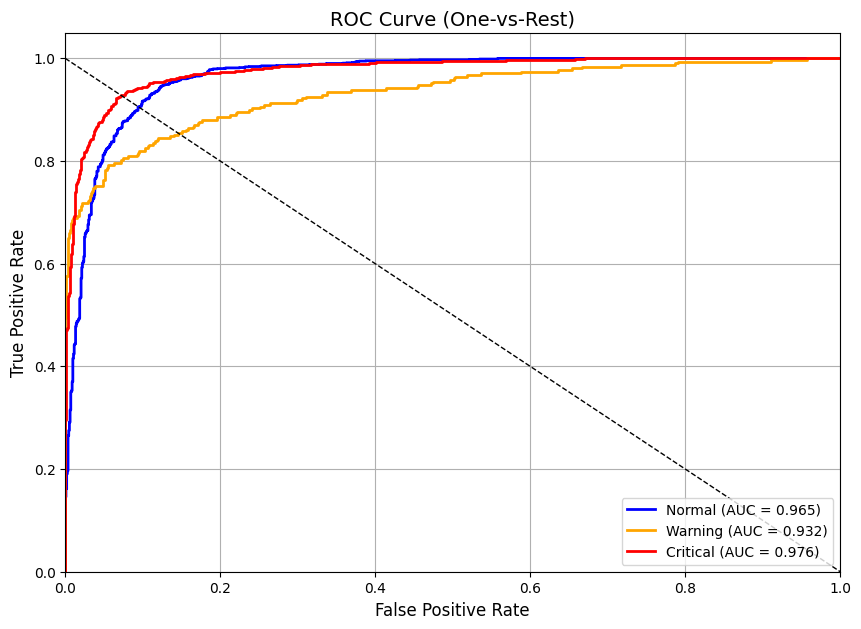

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for one-vs-rest ROC
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = 3

# get predicted probabilities
y_score = model.predict([X_ecg_test_n, X_ppg_test_n])

# compute ROC curve + AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 7))

colors = ['blue', 'orange', 'red']
class_names = ['Normal', 'Warning', 'Critical']

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})"
    )

# Diagonal chance line
plt.plot([0, 1], [1, 0], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (One-vs-Rest)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/BIDMC_Fusion_Project/model/fusion_model.keras")

model.summary()

# Optional: print input shapes clearly
for i, inp in enumerate(model.inputs):
    print(f"Input {i} shape:", inp.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 360)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 360)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 360, 1)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 360, 1)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 360, 16)   │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 360, 16)   │        128 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 180, 16)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 180, 16)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 180, 32)   │      2,592 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 180, 32)   │      2,592 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 90, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 90, 32)    │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 90, 64)    │      6,208 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 90, 64)    │      6,208 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 52,616 (205.54 KB)

 Trainable params: 26,307 (102.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,309 (102.77 KB)

Input 0 shape: (None, 360)
Input 1 shape: (None, 360)
